In [1]:
#This is based off of Bloom lab's SARS-CoV-2 RBD DMS at: https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/process_ccs_B1351.ipynb

In [2]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets
import alignparse.consensus
from alignparse.utils import InFrameDeletionsToSubs


import dms_variants
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import yaml

from Bio import SeqIO

warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
'''
the considered region for error rates can be changed to only the mutated region (mut_region_mutations)
or to the entire gene (gene_mutations) - the publication uses the entire gene
'''

background = "SN89"
considered_region='gene_mutations'

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using pandas version {pd.__version__}")

Using alignparse version 0.6.2
Using dms_variants version 1.4.3
Using pandas version 2.0.0


In [5]:
#open configuration file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [6]:
#make directory
os.makedirs(config['process_ccs_dir'], exist_ok=True)

In [7]:
'''
you must save the files into the config['pacbio_runs'] location in the configuration yaml file 
using the name rep#_background_runletter_ccs
'''


pacbio_runs = pd.read_csv(config['pacbio_runs'], dtype=str).drop(columns=['ccs'])
pacbio_runs['name'] = pacbio_runs['library'] + "_" + pacbio_runs['bg'] + "_" + pacbio_runs['run']
pacbio_runs['fastq'] = config['ccs_dir'] + "/" + pacbio_runs['name'] + "_ccs.fastq.gz"
pacbio_runs = pacbio_runs[pacbio_runs['bg'] == background]

pacbio_runs

,library,bg,run,name,fastq
5,rep1,SN89,A,rep1_SN89_A,results/ccs/rep1_SN89_A_ccs.fastq.gz
6,rep2,SN89,A,rep2_SN89_A,results/ccs/rep2_SN89_A_ccs.fastq.gz
7,rep2,SN89,B,rep2_SN89_B,results/ccs/rep2_SN89_B_ccs.fastq.gz


In [8]:
print(f"Reading amplicons from {config['amplicons_' + background]}")
print(f"Reading feature parse specs from {config['feature_parse_specs_' + background]}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicons_' + background],
                feature_parse_specs=config['feature_parse_specs_' + background])

Reading amplicons from data/SN89.gb
Reading feature parse specs from data/feature_parse_specs_SN89.yaml


Saving plot to results/process_ccs/amplicons_SN89.pdf


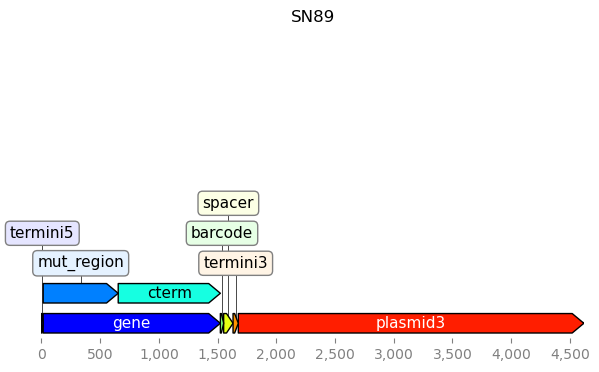

In [9]:
#generates a line plot showing the different annotations of the target, just to confirm
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=4,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['process_ccs_dir'], 'amplicons_'+background+'.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

In [10]:
#this sets the mapper to the minimap2, use OPTIONS_CODON_DMS which is good for sequences without large deletions and/or introns
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

#This will print out the minimap2 version and the options included with OPTIONS_CODON_DMS, you can find the description of these options on bloom's website
print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.22-r1101 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


In [11]:
#this will align and parse the reads and provide the readstats for the aligned and filtered (based on the feature_parse_specs config)
#this is the longest step of the whole process
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

In [12]:
readstats

,name,library,run,category,count
0,rep1_SN89_A,rep1,A,aligned SN89,1209100
1,rep1_SN89_A,rep1,A,filtered SN89,114555
2,rep1_SN89_A,rep1,A,unmapped,18183
3,rep2_SN89_A,rep2,A,aligned SN89,624387
4,rep2_SN89_A,rep2,A,filtered SN89,89812
5,rep2_SN89_A,rep2,A,unmapped,16013
6,rep2_SN89_B,rep2,B,aligned SN89,614480
7,rep2_SN89_B,rep2,B,filtered SN89,97576
8,rep2_SN89_B,rep2,B,unmapped,15564


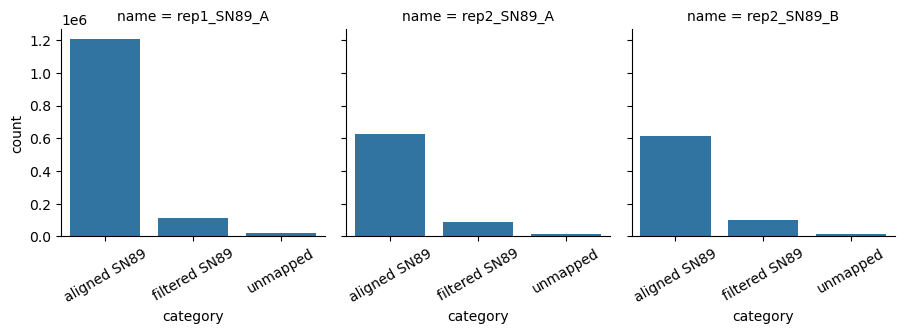

In [13]:
g = sns.FacetGrid(readstats, col='name', col_wrap=4)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

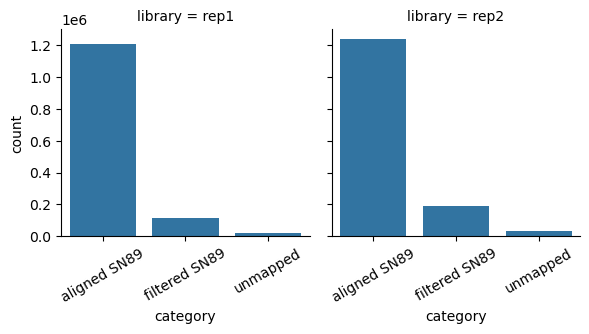

In [14]:
g = sns.FacetGrid(readstats.groupby(['library', 'category']).sum().reset_index(), col='library', col_wrap=2)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

In [15]:
filtered_df = pd.concat(df.assign(target=target) for target, df in filtered.items())
filtered_df = filtered_df.groupby(['library', 'name', 'run', 'filter_reason']).size().rename('count').reset_index()
filtered_df['tot_reason_frac'] = filtered_df.groupby('filter_reason')['count'].transform('sum') / filtered_df['count'].sum()
other_cutoff = 0.02  # group as "other" reasons with <= this frac
filtered_df['filter_reason'] = filtered_df['filter_reason'].where(filtered_df['tot_reason_frac'] > other_cutoff, 'other')

In [16]:
pd.set_option('display.max_rows', None)
filtered_df

,library,name,run,filter_reason,count,tot_reason_frac
0,rep1,rep1_SN89_A,A,other,207,0.001954
1,rep1,rep1_SN89_A,A,barcode mutation_nt_count,41758,0.287985
2,rep1,rep1_SN89_A,A,other,41,0.000295
3,rep1,rep1_SN89_A,A,gene clip3,4044,0.031698
4,rep1,rep1_SN89_A,A,other,1040,0.006554
5,rep1,rep1_SN89_A,A,other,7,0.000056
6,rep1,rep1_SN89_A,A,plasmid3 clip3,22298,0.239946
7,rep1,rep1_SN89_A,A,other,15,0.000093
8,rep1,rep1_SN89_A,A,other,1060,0.013983
9,rep1,rep1_SN89_A,A,query_clip5,3409,0.032403


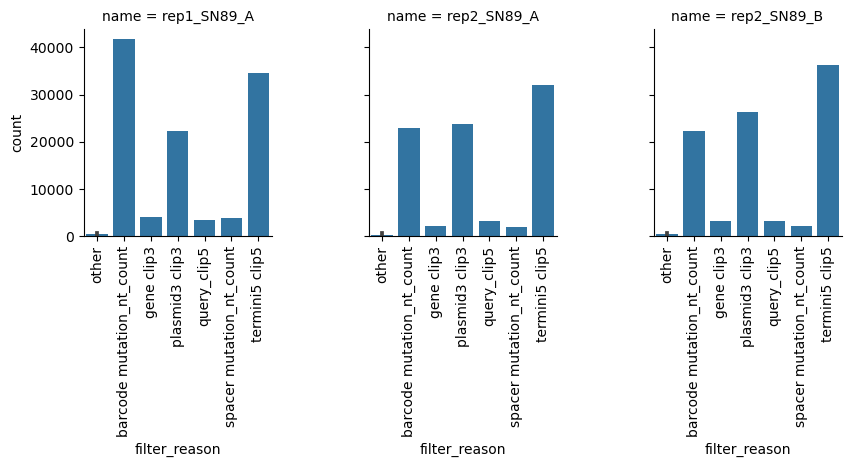

In [17]:
#plot why reads were filtered out, this can direct you to adjust the feature_parse_specs file
g = sns.FacetGrid(filtered_df, col='name')
g.map_dataframe(sns.barplot, x='filter_reason', y='count', order=filtered_df['filter_reason'].unique())
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=90)

In [18]:
pd.set_option('display.max_rows', 10)
aligned_df = pd.concat([df.assign(target=target) for target, df in aligned.items()])
aligned_df = aligned_df.drop(columns=['query_clip5', 'query_clip3', 'run','name'])
aligned_df = aligned_df.rename(columns={'barcode_sequence': 'barcode'})
aligned_df

,library,query_name,gene_mutations,gene_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target
0,rep1,m64408e_230601_183942/0/ccs,del15to15 ins235CA ins421G A478T ins669T ins69...,0.996121,del15to15 ins235CA ins421G A478T,0.996157,ins30T ins59A ins132A,0.996095,TCTTGCGAATTAAGCTAACGCAGCATGT,0.999748,SN89
1,rep1,m64408e_230601_183942/3/ccs,A76G A77C G78A,1.000000,A76G A77C G78A,1.000000,,1.000000,TCTTGGCTCTTGAGCTTCCCTAGTGAGC,1.000000,SN89
2,rep1,m64408e_230601_183942/4/ccs,C379T T381C,0.999958,C379T T381C,0.999999,,0.999927,TCTTATTGTCCAAGCTTGAAAGACGCCT,1.000000,SN89
3,rep1,m64408e_230601_183942/12/ccs,del501to503 ins874GG ins1208T ins1473C,0.998123,del501to503,0.999878,ins235GG ins569T ins834C,0.996845,TCTTACGGCGATAGCTTGTGATCGATTG,0.999908,SN89
4,rep1,m64408e_230601_183942/15/ccs,T187A,1.000000,T187A,1.000000,,1.000000,TCTTATCCGACGAGCTCCTGACGACTCC,1.000000,SN89
...,...,...,...,...,...,...,...,...,...,...,...
2447962,rep2,m64408e_230605_220754/180554521/ccs,C340T T341A G342T ins1008CCCCCCC,0.999468,C340T T341A G342T,0.999969,ins369CCCCCCC,0.999103,TCTTGCAGTGTGAGCTTGGATCATGCAT,1.000000,SN89
2447963,rep2,m64408e_230605_220754/180554525/ccs,ins286A T469A,1.000000,ins286A T469A,1.000000,,1.000000,TCTTTAATAGCGAGCTCATCCGAGCAAC,1.000000,SN89
2447964,rep2,m64408e_230605_220754/180554555/ccs,del108to108 del250to250 A274G A275G T276A del4...,0.996836,del108to108 del250to250 A274G A275G T276A del4...,0.995425,C222G G223C ins504A,0.997866,TCTTTCAACCGCAGCTACGATTTGCGGC,0.999998,SN89
2447965,rep2,m64408e_230605_220754/180554580/ccs,T488G C489G,1.000000,T488G C489G,1.000000,,1.000000,TCTTTTTGGACAAGCTTGCTCCCTTTCA,1.000000,SN89


In [19]:
#this saves the processed ccs file
aligned_df.to_csv(config['processed_ccs_file' + '_' + background], index=False)


print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file' + '_' + background]}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs_SN89.csv.


In [20]:
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

In [21]:
processed_ccs = pd.read_csv(config['processed_ccs_file' + '_' + background], na_filter=None)

nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 2447967 CCSs from 2 libraries and 1 targets.


In [22]:
#displays number of CCSs and unique barcodes in all processed targets/reps
display_ccs = processed_ccs.groupby(['target', 'library']).aggregate(total_CCSs=('barcode', 'size'),
                                                                     unique_barcodes=('barcode', 'nunique'))
display_ccs['avg_CCSs_per_barcode'] = display_ccs['total_CCSs'] / display_ccs['unique_barcodes']
display_ccs['avg_CCSs_per_barcode'] = display_ccs['avg_CCSs_per_barcode'].round(2)

display_ccs

total_CCSs  unique_barcodes  avg_CCSs_per_barcode
target library                                                   
SN89   rep1        1209100            71425                 16.93
       rep2        1238867            82656                 14.99

In [23]:
#set max_error_rate in config.yaml file

error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')
    
processed_ccs['barcode_error'] = (1-processed_ccs['barcode_accuracy']).clip(lower=error_rate_floor)
processed_ccs['gene_error'] = (1-processed_ccs['gene_accuracy']).clip(lower=error_rate_floor)

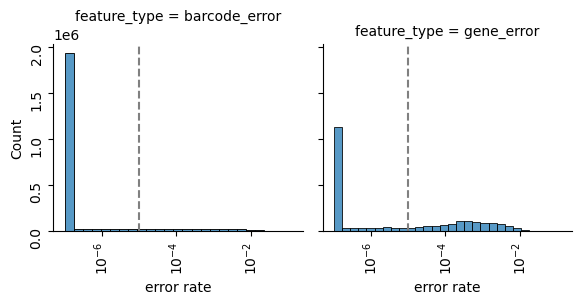

In [24]:
#plot error rates
g = sns.FacetGrid(processed_ccs.melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'), col='feature_type')
g.map_dataframe(sns.histplot, x='error rate', bins=25, log_scale=True)
g.refline(x=config['max_error_rate'])
g.tick_params(labelrotation=90)

In [25]:
processed_ccs['retained'] = ((processed_ccs['gene_error'] < config['max_error_rate']) &
                              (processed_ccs['barcode_error']    < config['max_error_rate']))

In [26]:
#retained based on error rate
data = processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library']).groupby(['xlabel', 'retained']).size().rename('count').reset_index()
data

,xlabel,retained,count
0,"SN89, rep1",False,497551
1,"SN89, rep1",True,711549
2,"SN89, rep2",False,544838
3,"SN89, rep2",True,694029


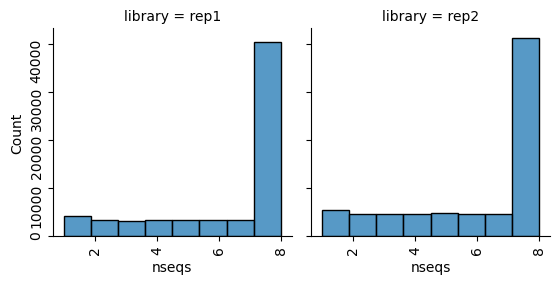

In [27]:
#plot histogram for how many barcodes have how many CCSs associated with them
max_count = 8 # in plot, group all barcodes with >= this many counts

data = processed_ccs.query('retained').groupby(['library', 'barcode']).size().rename('nseqs').reset_index()
data['nseqs'] = data['nseqs'].clip(upper=max_count)

g = sns.FacetGrid(data, col='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=8)
g.tick_params(labelrotation=90)

In [28]:
processed_ccs = processed_ccs.reset_index(drop=True)

#add indel columns, what you put as mutation_col is where it will look to see if there are indels there
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col=considered_region,
                                                       n_indel_col='n_indels',
                                                       del_str_col='del',
                                                       n_del_col='n_dels',
                                                       n_ins_col='n_ins')

processed_ccs['has_indel'] = (processed_ccs['n_indels'] > 0).astype(bool)
processed_ccs['has_ins'] = (processed_ccs['n_ins'] > 0).astype(bool)
processed_ccs['has_del'] = (processed_ccs['n_dels'] > 0).astype(bool)

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
processed_ccs

,library,query_name,gene_mutations,gene_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,del,n_dels,n_ins,n_indels,has_indel,has_ins,has_del
0,rep1,m64408e_230601_183942/0/ccs,del15to15 ins235CA ins421G A478T ins669T ins69...,0.996121,del15to15 ins235CA ins421G A478T,0.996157,ins30T ins59A ins132A,0.996095,TCTTGCGAATTAAGCTAACGCAGCATGT,0.999748,SN89,2.519982e-04,3.878686e-03,False,del15to15,1,5,6,True,True,True
1,rep1,m64408e_230601_183942/3/ccs,A76G A77C G78A,1.000000,A76G A77C G78A,1.000000,,1.000000,TCTTGGCTCTTGAGCTTCCCTAGTGAGC,1.000000,SN89,1.000000e-07,1.121831e-07,True,,0,0,0,False,False,False
2,rep1,m64408e_230601_183942/4/ccs,C379T T381C,0.999958,C379T T381C,0.999999,,0.999927,TCTTATTGTCCAAGCTTGAAAGACGCCT,1.000000,SN89,1.000000e-07,4.209868e-05,False,,0,0,0,False,False,False
3,rep1,m64408e_230601_183942/12/ccs,del501to503 ins874GG ins1208T ins1473C,0.998123,del501to503,0.999878,ins235GG ins569T ins834C,0.996845,TCTTACGGCGATAGCTTGTGATCGATTG,0.999908,SN89,9.181578e-05,1.877197e-03,False,del501to503,1,3,4,True,True,True
4,rep1,m64408e_230601_183942/15/ccs,T187A,1.000000,T187A,1.000000,,1.000000,TCTTATCCGACGAGCTCCTGACGACTCC,1.000000,SN89,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447962,rep2,m64408e_230605_220754/180554521/ccs,C340T T341A G342T ins1008CCCCCCC,0.999468,C340T T341A G342T,0.999969,ins369CCCCCCC,0.999103,TCTTGCAGTGTGAGCTTGGATCATGCAT,1.000000,SN89,1.000000e-07,5.321299e-04,False,,0,1,1,True,True,False
2447963,rep2,m64408e_230605_220754/180554525/ccs,ins286A T469A,1.000000,ins286A T469A,1.000000,,1.000000,TCTTTAATAGCGAGCTCATCCGAGCAAC,1.000000,SN89,1.000000e-07,1.000000e-07,True,,0,1,1,True,True,False
2447964,rep2,m64408e_230605_220754/180554555/ccs,del108to108 del250to250 A274G A275G T276A del4...,0.996836,del108to108 del250to250 A274G A275G T276A del4...,0.995425,C222G G223C ins504A,0.997866,TCTTTCAACCGCAGCTACGATTTGCGGC,0.999998,SN89,2.365592e-06,3.164205e-03,False,del108to108 del250to250 del415to415,3,1,4,True,True,True
2447965,rep2,m64408e_230605_220754/180554580/ccs,T488G C489G,1.000000,T488G C489G,1.000000,,1.000000,TCTTTTTGGACAAGCTTGCTCCCTTTCA,1.000000,SN89,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False


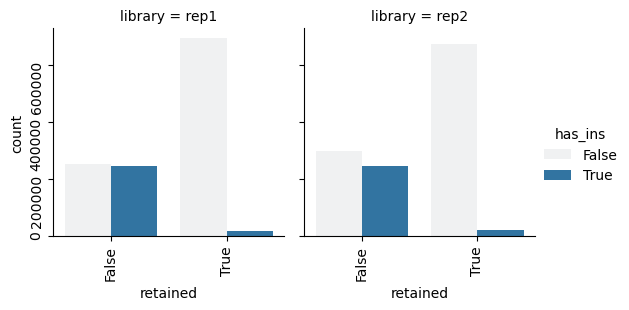

In [30]:
#plot whether the sequences retained after the error rate filter have insertions

g = sns.FacetGrid(processed_ccs, col='library')
g.map_dataframe(sns.countplot, x='retained', hue='has_ins')
g.tick_params(labelrotation=90)
g.add_legend(title='has_ins')

In [31]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no ins', 'retained and not has_ins'),
        ('10X accuracy', f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no ins', f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_ins")
        ]:
    # get just CCSs in that category
    query_df = processed_ccs.query(query_str)
        
    # compute empirical accuracy
    emp_acc_df = alignparse.consensus.empirical_accuracy(query_df,
                                                mutation_col=considered_region,
                                                group_cols='barcode',
                                                accuracy_col='accuracy',
                                               )
    emp_acc_df['description'] = desc
    query_df = emp_acc_df.merge(query_df.groupby('library').size().rename('number_CCSs').reset_index())
    empirical_acc.append(query_df)

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = pd.concat(empirical_acc, ignore_index=True, sort=False)
empirical_acc['description'] = pd.Categorical(empirical_acc['description'],
                                                 empirical_acc['description'].unique(),
                                                 ordered=True)
empirical_acc['actual'] = np.where(empirical_acc['description'] == 'retained, no ins', True, False)

In [32]:
empirical_acc

,library,accuracy,description,number_CCSs,actual
0,rep1,0.942060,retained,711549,False
1,rep2,0.933013,retained,694029,False
2,rep1,0.963674,"retained, no ins",694026,True
3,rep2,0.957981,"retained, no ins",674179,True
4,rep1,0.954788,10X accuracy,632266,False
5,rep2,0.949270,10X accuracy,606849,False
6,rep1,0.969534,"10X accuracy, no ins",621221,False
7,rep2,0.966531,"10X accuracy, no ins",594481,False


In [33]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col=considered_region,
                        )

consensus.head()

,library,barcode,target,gene_mutations,variant_call_support
0,rep1,AAGTAGAGAGCTAGCTATATACACTTCC,SN89,T623A C624A ins1510TCTT,2
1,rep1,AATTGCGTCTCCAGCTACGGACTACGTT,SN89,G625A C626A C1503A A1504G T1506G ins1500TTACGT...,12
2,rep1,AATTGCGTCTCCAGCTTCAACCCAACTC,SN89,T173A G174A ins1507TAATCTTGAACGATTAGCTGAGTG,14
3,rep1,AATTGCGTCTCCAGCTTGGCGAGTAGCA,SN89,C1503A A1504G T1506G del130to132 ins1500ACGTGG...,20
4,rep1,ACATCTGGACAAAGCTACCTTCCCCTTT,SN89,C235T A236C C237A ins1510AGTG,19


In [34]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col=considered_region,
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    n_ins_col='number_of_insertions',
                    n_del_col='number_of_deletions',
                    del_str_col='deletion',
                    overwrite_cols=True)

consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,deletion,number_of_deletions,number_of_insertions,number_of_indels
0,rep1,AAGTAGAGAGCTAGCTATATACACTTCC,SN89,T623A C624A ins1510TCTT,2,T623A C624A,,0,1,1
1,rep1,AATTGCGTCTCCAGCTACGGACTACGTT,SN89,G625A C626A C1503A A1504G T1506G ins1500TTACGT...,12,G625A C626A C1503A A1504G T1506G,,0,1,1
2,rep1,AATTGCGTCTCCAGCTTCAACCCAACTC,SN89,T173A G174A ins1507TAATCTTGAACGATTAGCTGAGTG,14,T173A G174A,,0,1,1
3,rep1,AATTGCGTCTCCAGCTTGGCGAGTAGCA,SN89,C1503A A1504G T1506G del130to132 ins1500ACGTGG...,20,C1503A A1504G T1506G,del130to132,1,1,2
4,rep1,ACATCTGGACAAAGCTACCTTCCCCTTT,SN89,C235T A236C C237A ins1510AGTG,19,C235T A236C C237A,,0,1,1
...,...,...,...,...,...,...,...,...,...,...
125353,rep2,TTTAGTTGACATAGCTCCTCCAACCACC,SN89,C428A C429T ins1510TC,1,C428A C429T,,0,1,1
125354,rep2,TTTCGCCTAGATAGCTTCATCTCAATGC,SN89,A256C C257A G258A ins1510TC,1,A256C C257A G258A,,0,1,1
125355,rep2,TTTTAATCAGGGAGCTGCTATTCTGTAC,SN89,G448T C449G T450C ins1510TC,1,G448T C449G T450C,,0,1,1
125356,rep2,TTTTACCGCATCAGCTGCTCCTACGCTC,SN89,G382T T383C ins1510TC,3,G382T T383C,,0,1,1


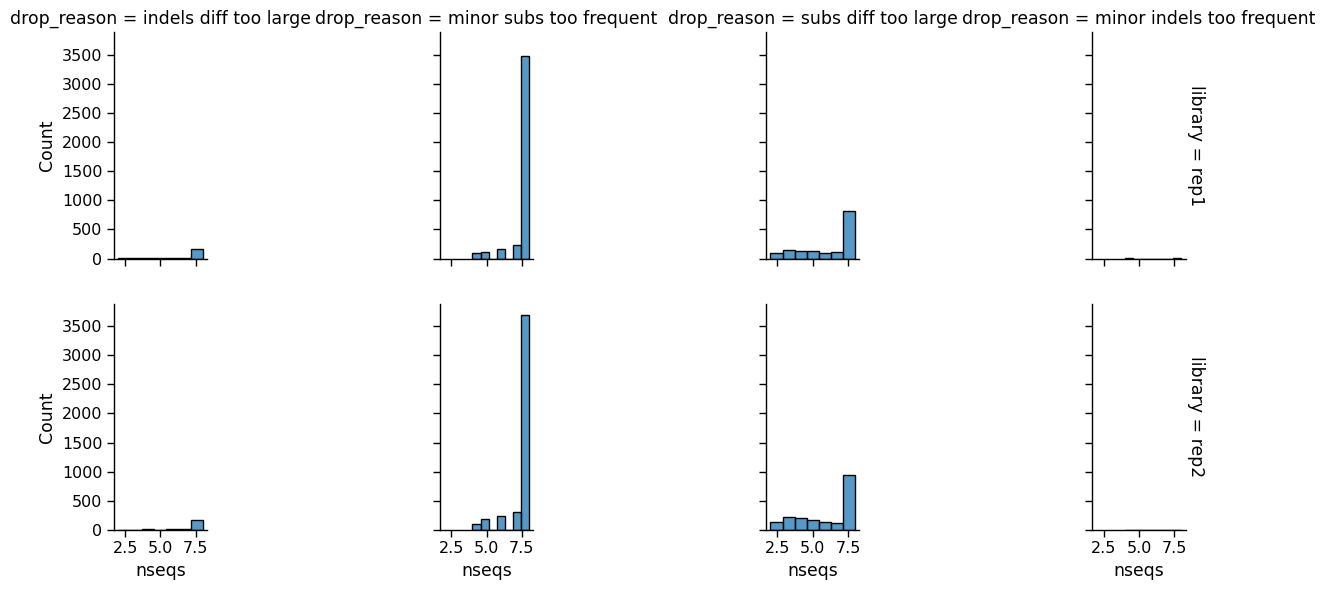

In [35]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

#below is from https://wckdouglas.github.io/2016/12/seaborn_annoying_title
with sns.plotting_context('paper', font_scale = 1.3):
    p = sns.FacetGrid(data = dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                      col = 'drop_reason',
                      row = 'library',
                      margin_titles=True)
    
p.map_dataframe(sns.histplot, x='nseqs', bins=7) 
plt.subplots_adjust(hspace=0.2, wspace=2.5)

In [36]:
max_variant_call_support = 6  # group variants with >= this much support
consensus['variant_call_support'] = consensus['variant_call_support'].clip(upper=max_variant_call_support)
consensus['ins_state'] = np.where(consensus['number_of_insertions'] > 0, 'has ins', 'no ins')

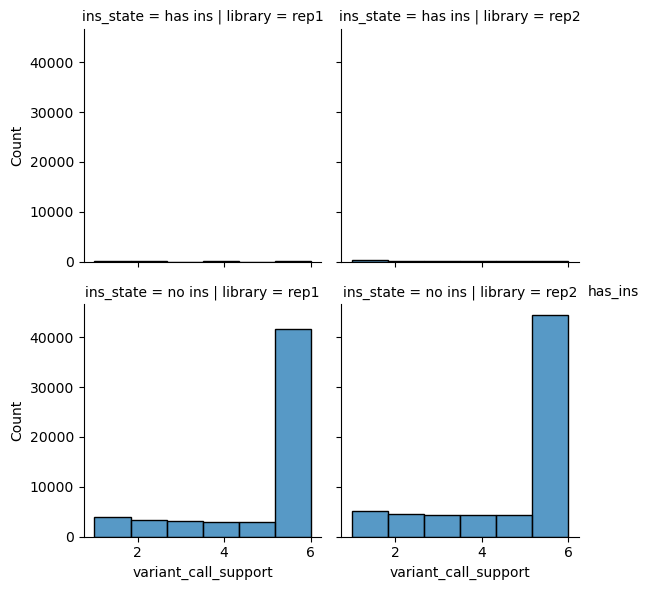

In [37]:
g = sns.FacetGrid(consensus, col='library', row='ins_state')
g.map_dataframe(sns.histplot, x='variant_call_support', bins=6)
g.add_legend(title='has_ins')

In [38]:
consensus=consensus.query('number_of_insertions == 0')
consensus=consensus.query('number_of_deletions <= 1')

In [39]:
#change dels to -, determine if deletion is out of frame and remove any that are not in frame
if considered_region == 'gene_mutations':
    region_seq = targets.get_target(background).get_feature('gene').seq
if considered_region == 'mut_region_mutations':
    region_seq = targets.get_target(background).get_feature('mut_region').seq
    
consensus.reset_index(drop=True)

deltosubs=InFrameDeletionsToSubs(region_seq)
new_subs=[]
for x in consensus[considered_region]:  
    new_subs.append(deltosubs.dels_to_subs(x))
consensus['substitutions']=new_subs
consensus['deletion_out_of_frame']=consensus['substitutions'].str.contains('del')
consensus=consensus[consensus['deletion_out_of_frame']==False]
consensus=consensus.drop(['deletion'],axis='columns')
consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_deletions,number_of_insertions,number_of_indels,ins_state,deletion_out_of_frame
16,rep1,ACTTTTCGTTGTAGCTGACTTCTATTTA,SN89,G325A G326A C327A,6,G325A G326A C327A,0,0,0,no ins,False
122,rep1,GCTTTTCGTTGTAGCTTGCATCCTAGAT,SN89,G325T,6,G325T,0,0,0,no ins,False
128,rep1,TATTAACTGAGCAGCTCTCGTCACTTCA,SN89,A337C T339A,3,A337C T339A,0,0,0,no ins,False
129,rep1,TATTAGGAAACAAGCTTATATGATTATG,SN89,C403A C404T,6,C403A C404T,0,0,0,no ins,False
130,rep1,TATTAGTCAGTTAGCTGATTATCTCCAC,SN89,A283C G284A C285A,6,A283C G284A C285A,0,0,0,no ins,False
...,...,...,...,...,...,...,...,...,...,...,...
125336,rep2,TGTTCTTGGTTGAGCTATTCACCGTAGC,SN89,A247C A248C,6,A247C A248C,0,0,0,no ins,False
125337,rep2,TGTTGTCGGGAAAGCTGGCGGCCTTGAC,SN89,G460A T461A,6,G460A T461A,0,0,0,no ins,False
125338,rep2,TGTTTACGACCGAGCTTAAATGCGGGAT,SN89,del315to317,6,G316- A317- G318-,1,0,1,no ins,False
125339,rep2,TGTTTTGCTAGGAGCTCGACACTCGTCA,SN89,T85A G86T,6,T85A G86T,0,0,0,no ins,False


In [40]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file' + '_' + background]}")
      
(consensus
 [['target', 'library', 'barcode', considered_region,'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file' + '_' + background], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file' + '_' + background], na_filter=None)
    .head()
    .to_html(index=False)
    )) 

Writing nucleotide variants to results/variants/nucleotide_variant_table_SN89.csv
Here are the first few lines of this file:


target,library,barcode,gene_mutations,substitutions,variant_call_support
SN89,rep1,ACTTTTCGTTGTAGCTGACTTCTATTTA,G325A G326A C327A,G325A G326A C327A,6
SN89,rep1,GCTTTTCGTTGTAGCTTGCATCCTAGAT,G325T,G325T,6
SN89,rep1,TATTAACTGAGCAGCTCTCGTCACTTCA,A337C T339A,A337C T339A,3
SN89,rep1,TATTAGGAAACAAGCTTATATGATTATG,C403A C404T,C403A C404T,6
SN89,rep1,TATTAGTCAGTTAGCTGATTATCTCCAC,A283C G284A C285A,A283C G284A C285A,6


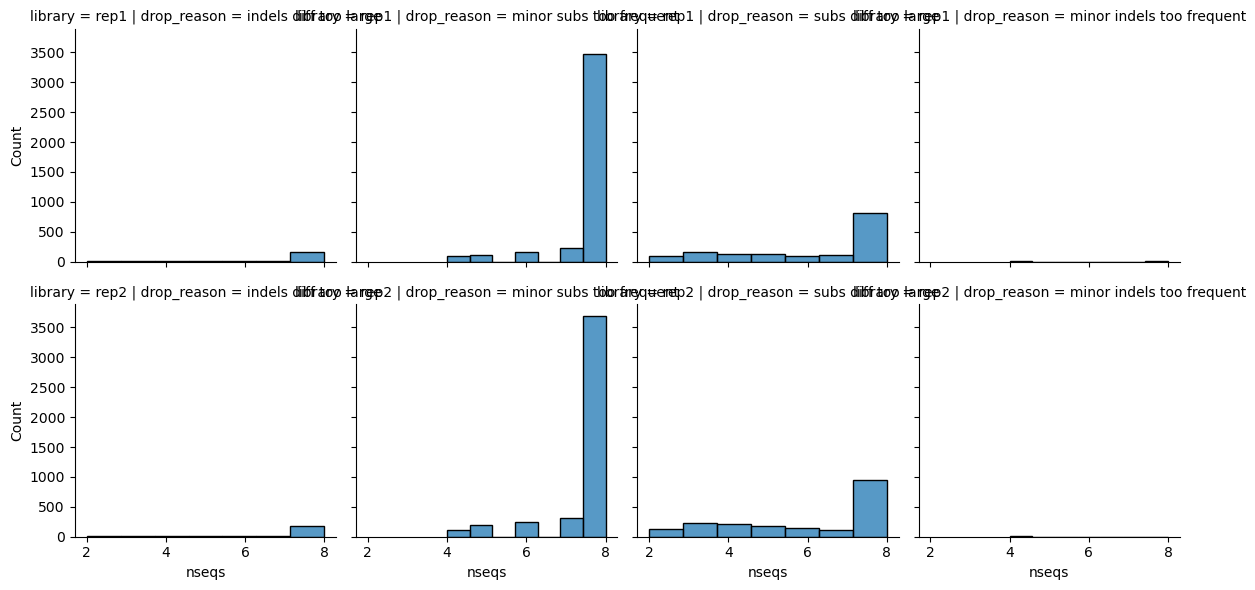

In [41]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

g = sns.FacetGrid(dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                  col='drop_reason', row='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=7)


In [42]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_' + background],
                                     feature_parse_specs=config['feature_parse_specs_' + background])
geneseq = targets.get_target(background).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {background} from {config['amplicons_' + background]}")
     

Read gene of 1509 nts for SN89 from data/SN89.gb


In [43]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file_' + background],
                geneseq=geneseq,
                primary_target=background,
                allowgaps=True,
                substitutions_col='substitutions'
                )

In [44]:
print('Number of variants for each replicate:')
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

Number of variants for each replicate:


library,rep1,rep2,all libraries
target,,,
SN89,57375,66385,123760


In [45]:
variants_df=variants.barcode_variant_df
variants_df

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,SN89,rep1,ACTTTTCGTTGTAGCTGACTTCTATTTA,6,GGC109AAA,G109K,1,1
1,SN89,rep1,GCTTTTCGTTGTAGCTTGCATCCTAGAT,6,GGC109TGC,G109C,1,1
2,SN89,rep1,TATTAACTGAGCAGCTCTCGTCACTTCA,3,AAT113CAA,N113Q,1,1
3,SN89,rep1,TATTAGGAAACAAGCTTATATGATTATG,6,CCG135ATG,P135M,1,1
4,SN89,rep1,TATTAGTCAGTTAGCTGATTATCTCCAC,6,AGC95CAA,S95Q,1,1
...,...,...,...,...,...,...,...,...
123755,SN89,rep2,TGTTCTTGGTTGAGCTATTCACCGTAGC,6,AAA83CCA,K83P,1,1
123756,SN89,rep2,TGTTGTCGGGAAAGCTGGCGGCCTTGAC,6,GTA154AAA,V154K,1,1
123757,SN89,rep2,TGTTTACGACCGAGCTTAAATGCGGGAT,6,GAG106---,E106-,1,1
123758,SN89,rep2,TGTTTTGCTAGGAGCTCGACACTCGTCA,6,TGG29ATG,W29M,1,1


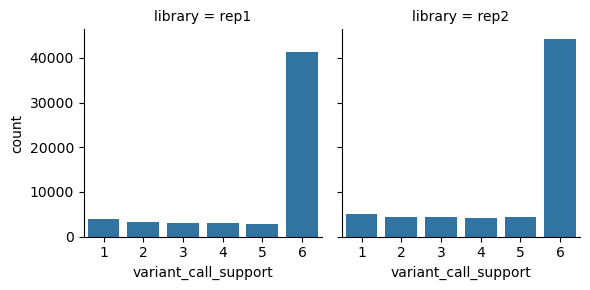

In [46]:
#show distribution of sequences with x number of ccs supporting each variant
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='variant_call_support')
g.tick_params(labelrotation=0)

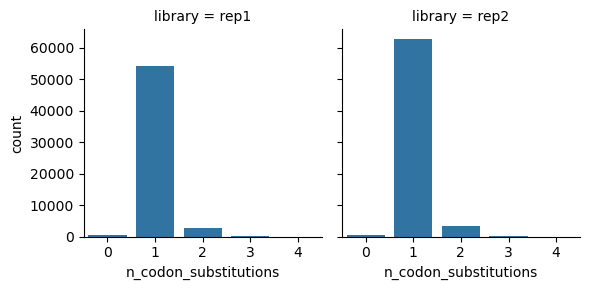

In [47]:
#show distribution of sequences with x number of codon substitutions
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='n_codon_substitutions')
g.tick_params(labelrotation=0)

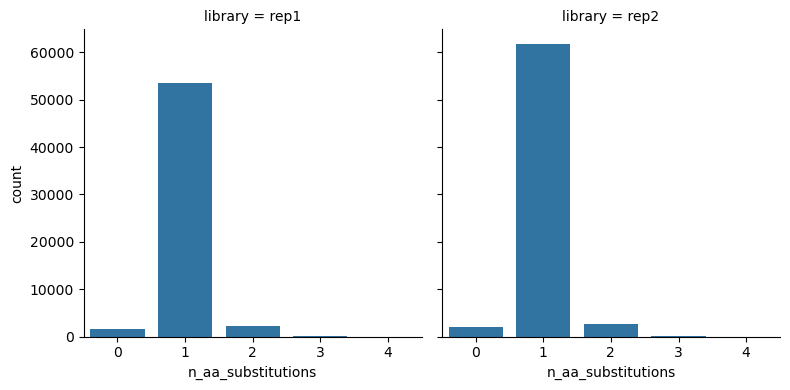

In [48]:
#show distribution of sequences with x number of amino acid substitutions
g = sns.FacetGrid(variants_df, col='library', height=4)
g.map_dataframe(sns.countplot, x='n_aa_substitutions')
g.tick_params(labelrotation=0)

In [49]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
SN89,rep1,ACTTTTCGTTGTAGCTGACTTCTATTTA,6,GGC109AAA,G109K,1,1
SN89,rep1,GCTTTTCGTTGTAGCTTGCATCCTAGAT,6,GGC109TGC,G109C,1,1
SN89,rep1,TATTAACTGAGCAGCTCTCGTCACTTCA,3,AAT113CAA,N113Q,1,1
SN89,rep1,TATTAGGAAACAAGCTTATATGATTATG,6,CCG135ATG,P135M,1,1
SN89,rep1,TATTAGTCAGTTAGCTGATTATCTCCAC,6,AGC95CAA,S95Q,1,1


In [50]:
print(f"Writing codon-variant table to {config['codon_variant_table_file_'+background]}")
print(f"Writing single codon-variant table to {config['codon_variant_table_file_'+background+'_single']}")


variants_df=variants.barcode_variant_df
variants_df.to_csv(config['codon_variant_table_file_'+background], index=False)
variants_df.query('n_codon_substitutions <= 1').to_csv(config['codon_variant_table_file_'+background+'_single'], index=False)

Writing codon-variant table to results/variants/codon_variant_table_SN89.csv
Writing single codon-variant table to results/variants/codon_variant_table_SN89_single.csv
